<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/Semantic_Segmentation_Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install transformers accelerate optuna torch-summary albumentations wandb opencv-python  evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━

In [ ]:
! unzip /content/drive/MyDrive/Dataset/All_Images.zip -d ./dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a060752xtsghhhe.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a070752pa8fulft.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a080752umzffj0l.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a090752ldfe1q7l.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0a07523vsmfyjl.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0b0752qln71nbz.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0c075211a634bl.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0d07529eo3r9of.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0e0752okistz37.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0f0752ie5puqfs.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0g07526lmsv551.png  
  inflating: ./dataset/All_Images/annotations/clqdbaaag0a0h0752r1f3mdyv.png  
  inflating: 

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os.path


dir="/content/dataset/All_Images"
image_data_dir=f'{dir}/images'
annotation_data_dir=f'{dir}/annotations'
dataset=[]
for index,item in enumerate(os.listdir(f"{image_data_dir}/")):
    name=item.split(".")[0]
    imageName=f"{image_data_dir}/{name}.jpg"
    annotationName=f"{annotation_data_dir}/{name}.png"
    if os.path.isfile(imageName) and os.path.isfile(annotationName):
      name=item.split(".")[0]
      image=Image.open(imageName)
      annotation=Image.open(annotationName)
      dataset.append({"_id":index,"pixel_values":image,"annotation":annotation})

new_data=dataset
train_data, test_data =  train_test_split(new_data,test_size=0.2,random_state=42)

print(f" Training Data {len(train_data)}")
print(f" Testing Data {len(test_data)}")


 Training Data 2400
 Testing Data 600


In [ ]:
id2label={ 5:'windowpane',4:'curtain',3:'blinds',2:'door',0:'wall',1:'floor'}


In [ ]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

palette = color_palette()


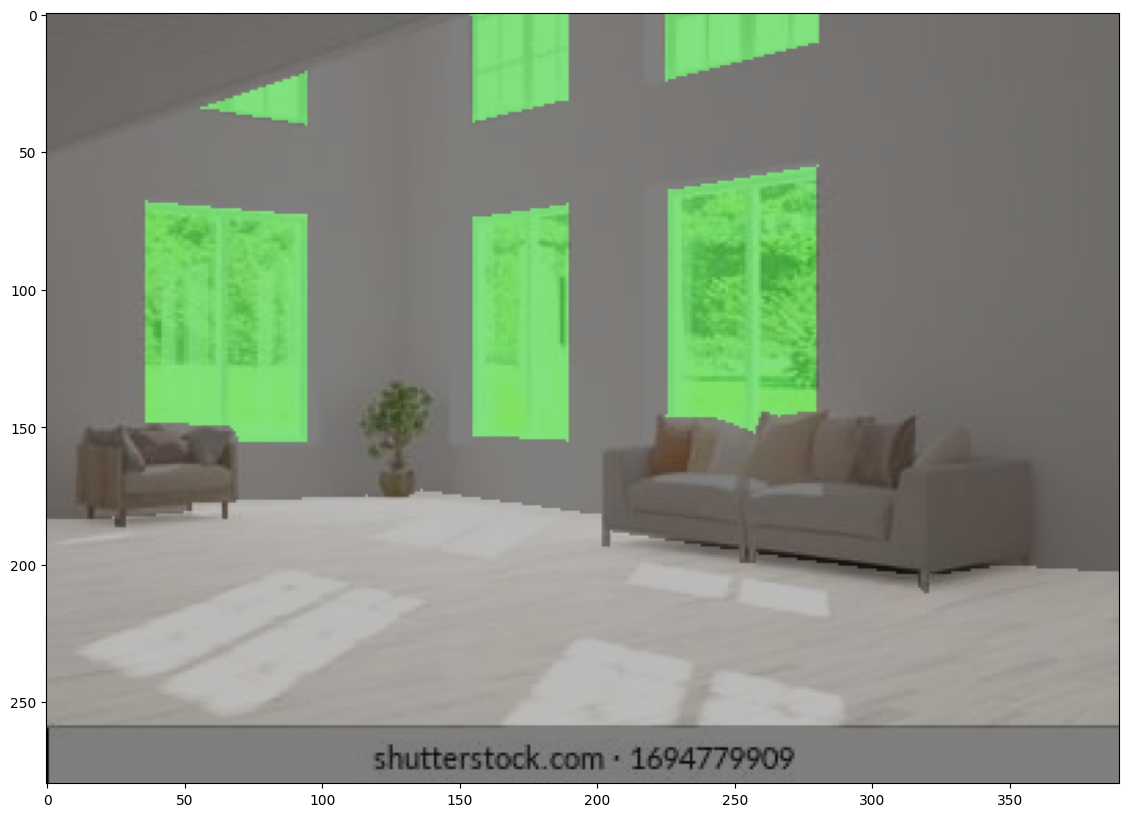

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
index=5
image=np.array(train_data[index]["annotation"])
segmentation_map=np.array(train_data[index]["annotation"])[...,0]
image=train_data[index]["pixel_values"]
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map - 1 == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]

img = np.array(image) * 0.5 + ground_truth_color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
import numpy as np
from torch.utils.data import Dataset
from transformers import MaskFormerImageProcessor
# Create a preprocessor
preprocessor = MaskFormerImageProcessor(do_reduce_labels=True,ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)


class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform,processor):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        original_image = np.array(self.dataset[idx]['pixel_values'])
        original_segmentation_map = np.array(self.dataset[idx]["annotation"])[...,0]

        transformed = self.transform(image=original_image, mask=original_segmentation_map)
        image, segmentation_map = transformed['image'], transformed['mask']

        # convert to C, H, W
        image = image.transpose(2,0,1)
        inputs = self.processor([image],segmentation_maps=[segmentation_map],return_tensors="pt")
        inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

transform = A.Compose([
    A.Resize(width=512, height=512),
    #A.RandomResizedCrop(width=512, height=512, scale=(0.5, 1.0)),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=45),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])



train_dataset = ImageSegmentationDataset(train_data, transform=transform,processor = preprocessor)
test_dataset = ImageSegmentationDataset(test_data, transform=transform,processor = preprocessor)

In [ ]:
labels = [id2label[label] for label in np.unique(segmentation_map)]
print(labels)

['wall', 'floor', 'windowpane']


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [ ]:
import torch
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 512, 512])
pixel_mask torch.Size([2, 512, 512])
class_labels torch.Size([3])
mask_labels torch.Size([3, 512, 512])


In [ ]:
import numpy as np
import torch
from torch import nn
import evaluate
num_labels = len(id2label)

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=True,
        )
        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics


In [ ]:
from transformers import EvalPrediction
from transformers import MaskFormerForInstanceSegmentation,MaskFormerConfig, Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
import evaluate

def model_init(trial=None):
    params = {}
    if trial:
        params = trial.params
    config = MaskFormerConfig.from_pretrained("facebook/maskformer-swin-large-ade")
    config.id2label = id2label
    config.label2id = {id2label[label]: index for index, label in enumerate(id2label)}
    config.dice_weight = params.get("dice_weight", 1.0)
    config.cross_entropy_weight = params.get("cross_entropy_weight", 1.0)
    config.mask_weight = params.get("mask_weight", 20.0)
    config.init_xavier_std = params.get("init_xavier_std", 1)
    config.init_std = params.get("init_std", 1)
    model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade", config=config, ignore_mismatched_sizes=True)
    return model


def optuna_hp_space(trial):
      return {
          "optim": trial.suggest_categorical('optim', ["adamw_torch"]),
          "learning_rate": trial.suggest_float("learning_rate", 5e-5, 1e-4, log=True),
          # "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [10, 12]),
          "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
          "num_decoder_layers": trial.suggest_int('num_decoder_layers', 6, 10),
          "auxiliary_loss_weight": trial.suggest_uniform('auxiliary_loss_weight', 0.1, 0.5),
          "dice_weight": trial.suggest_uniform('dice_weight', 0.1, 1),
          "cross_entropy_weight": trial.suggest_uniform('cross_entropy_weight', 0.1, 1),
          "mask_weight": trial.suggest_uniform("mask_weight", 0.0, 20.0),
          "init_xavier_std": trial.suggest_float("init_xavier_std", 0.5, 1.0),
          "init_std": trial.suggest_float("init_std", 0.5, 1.0),
          "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 50),
          "batch_size": trial.suggest_categorical("batch_size", [10]),
      }

training_args = TrainingArguments(
  output_dir="./output",
  save_strategy="epoch",
  evaluation_strategy="epoch",
  num_train_epochs=5,
  save_total_limit=2,
  #gradient_accumulation_steps=4,
#  gradient_checkpointing=True,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  eval_steps=1 ,
  save_steps =4,
  fp16=True,
  logging_steps =4,
  load_best_model_at_end =True
)

final_trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=preprocessor,
  #  compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of evaluations with no improvement after which training will be stopped
    early_stopping_threshold=0.01  # The improvement threshold to qualify as a significant change
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models 

config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/851M [00:00<?, ?B/s]

Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-large-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
best_run = final_trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=25
)

[I 2024-07-17 07:56:08,007] A new study created in memory with name: no-name-271ae528-1862-484f-b56f-ff1dc71852b6
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "auxiliary_loss_weight": trial.suggest_uniform('auxiliary_loss_weight', 0.1, 0.5),
<ipython-input-14-03c2f4b01c12>:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dice_weight": trial.suggest_uniform('di

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.496700,0.376971
2,0.316600,0.371196
3,0.413100,0.367064
4,0.364200,0.331248
5,0.302100,0.371092
6,0.267000,0.300851
7,0.288100,0.352168
8,0.302900,0.298919
9,0.265300,0.306571
10,0.262600,0.289324


[I 2024-07-17 08:45:26,361] Trial 0 finished with value: 0.29203251004219055 and parameters: {'optim': 'adamw_torch', 'learning_rate': 7.888974087012296e-05, 'weight_decay': 0.003941097774028512, 'num_decoder_layers': 9, 'auxiliary_loss_weight': 0.46500900312824434, 'dice_weight': 0.654306117394237, 'cross_entropy_weight': 0.6703901495734782, 'mask_weight': 13.309551154332691, 'init_xavier_std': 0.5246214934406829, 'init_std': 0.6749589108822236, 'num_train_epochs': 31, 'batch_size': 10}. Best is trial 0 with value: 0.29203251004219055.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

eval/loss,██▇▅█▂▆▂▃▁▂▁▃▄▂
eval/runtime,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁██████████████
eval/steps_per_second,▁██████████████
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▅▆▂█▄▄▄▃▂▅▂▂▁▃▁▄▂▃▂▆▂▂▁▂▂▁▃▁▂▂▁▂▂▂▂▁▂▁▁▃
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▄▅▅▅▄▅▃▅▃▂▂▃▃▃▂▂▂▂▂▂▁▂▂▂▂▁▂▁▁▂▂▂▁▁▂▁▁▁
eval/loss,0.29203
eval/runtime,24.1724


wandb: Currently logged in as: siddharthgupta2451. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.413000,0.324416
2,0.268700,0.376855
3,0.365500,0.280680
4,0.342200,0.296706
5,0.247900,0.286197
6,0.202700,0.243097
7,0.217600,0.247201
8,0.194400,0.241475
9,0.206500,0.215179
10,0.202300,0.232003


[I 2024-07-17 09:23:34,813] Trial 1 finished with value: 0.23369860649108887 and parameters: {'optim': 'adamw_torch', 'learning_rate': 5.853613947787382e-05, 'weight_decay': 0.002514930416417001, 'num_decoder_layers': 8, 'auxiliary_loss_weight': 0.12301168675243819, 'dice_weight': 0.6831455711925196, 'cross_entropy_weight': 0.6510191481783333, 'mask_weight': 5.673165346057689, 'init_xavier_std': 0.6307967810875813, 'init_std': 0.8162036154419907, 'num_train_epochs': 35, 'batch_size': 10}. Best is trial 1 with value: 0.23369860649108887.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

eval/loss,▆█▄▅▄▂▂▂▁▂▂▂
eval/runtime,▂▁▄▃▃▂▄▅▅▅▄█
eval/samples_per_second,▇█▅▆▆▇▅▄▄▄▅▁
eval/steps_per_second,▇█▅▆▆▇▅▄▄▄▄▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▆▃▄▃▄█▃▂▂▄▂▃▁▂▂▁▂▂▂▆▂▁▁▂▂▄▂▃▁▂▁▂▂▄▂▁▂▂▂
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▅▃▃▃▄▃▂▂▃▂▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▂▂▁▂▂▁▁▁▁▂▂▁▁▁
eval/loss,0.2337
eval/runtime,24.3908


Epoch,Training Loss,Validation Loss
1,0.498300,0.391266


[I 2024-07-17 09:27:02,957] Trial 2 finished with value: 0.39126577973365784 and parameters: {'optim': 'adamw_torch', 'learning_rate': 5.556893291042548e-05, 'weight_decay': 0.00025985928041153544, 'num_decoder_layers': 7, 'auxiliary_loss_weight': 0.17338759863397935, 'dice_weight': 0.8329611935373126, 'cross_entropy_weight': 0.2551764121752713, 'mask_weight': 17.771718877955628, 'init_xavier_std': 0.5054843681579473, 'init_std': 0.5179524861204017, 'num_train_epochs': 1, 'batch_size': 10}. Best is trial 1 with value: 0.23369860649108887.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,▇▆▃▂▂▂▂▂▂▂▂▁▂▂▁█▁▁▁▂▁▁▁▁▁▁▂▃▂▁▂▁▁▂▂▁▃▁▁▂
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.39127
eval/runtime,24.152


Epoch,Training Loss,Validation Loss
1,0.373500,0.294570
2,0.271200,0.279366
3,0.311800,0.264967
4,0.269200,0.241863
5,0.235000,0.238692
6,0.206600,0.221391
7,0.250900,0.239185
8,0.203800,0.225504
9,0.214500,0.213995
10,0.197800,0.211588


[I 2024-07-17 10:15:05,989] Trial 3 finished with value: 0.20160408318042755 and parameters: {'optim': 'adamw_torch', 'learning_rate': 5.001725510811859e-05, 'weight_decay': 0.0002834753048828533, 'num_decoder_layers': 10, 'auxiliary_loss_weight': 0.329243401127491, 'dice_weight': 0.6472198590727701, 'cross_entropy_weight': 0.16337883555630028, 'mask_weight': 12.421444386826899, 'init_xavier_std': 0.800003312608397, 'init_std': 0.6471085040570407, 'num_train_epochs': 18, 'batch_size': 10}. Best is trial 3 with value: 0.20160408318042755.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

eval/loss,█▇▆▄▄▃▄▃▂▂▂▁▁▂▁
eval/runtime,▄█▃▂▁▄▂▄▃▂▂▇▂▄▁
eval/samples_per_second,▅▁▆▇█▄▇▅▆▇▇▂▇▅█
eval/steps_per_second,▅▁▆▇█▅▇▅▆▇▇▂▇▅█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▂▁▃▂▂▂█▁▂▁▁▃▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▄▄▄▅▅▃▄▃▄▃▂▃▃▂▃▂▃▂▂▂▂▂▃▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁
eval/loss,0.2016
eval/runtime,24.123


Epoch,Training Loss,Validation Loss
1,0.412700,0.335270
2,0.262300,0.291768
3,0.310800,0.282684
4,0.344100,0.267188
5,0.250000,0.266589
6,0.197000,0.234832
7,0.283700,0.257887
8,0.217600,0.228363
9,0.189100,0.218919
10,0.200400,0.233786


[I 2024-07-17 10:52:34,119] Trial 4 finished with value: 0.22096648812294006 and parameters: {'optim': 'adamw_torch', 'learning_rate': 5.507705286759957e-05, 'weight_decay': 0.0025487805525744854, 'num_decoder_layers': 10, 'auxiliary_loss_weight': 0.40405858855788235, 'dice_weight': 0.8143304606457883, 'cross_entropy_weight': 0.5912666352820491, 'mask_weight': 4.5565074538780115, 'init_xavier_std': 0.5597961653437109, 'init_std': 0.7017334054539868, 'num_train_epochs': 33, 'batch_size': 10}. Best is trial 3 with value: 0.20160408318042755.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

eval/loss,█▅▅▄▄▂▃▂▁▂▃▁
eval/runtime,▂▃▄▇▅█▁▃▆▇▅▃
eval/samples_per_second,▇▆▅▂▄▁█▆▃▂▄▆
eval/steps_per_second,▇▆▅▂▄▁█▆▃▂▄▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▃▁▁▁█▁▁▁▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▅▃▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▁▁▂▁▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁
eval/loss,0.22097
eval/runtime,23.0384


Epoch,Training Loss,Validation Loss
1,0.449900,0.288973
2,0.258100,0.332766
3,0.388700,0.317650


[I 2024-07-17 11:07:52,305] Trial 5 pruned. 
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "auxiliary_loss_weight": trial.suggest_uniform('auxiliary_loss_weight', 0.1, 0.5),
<ipython-input-14-03c2f4b01c12>:30: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "dice_weight": trial.suggest_uniform('dice_weight', 0.1, 1),
<ipython-input-14-03c2f4b01c12>:31: FutureWarnin

eval/loss,▁█▆
eval/runtime,▅▁█
eval/samples_per_second,▄█▁
eval/steps_per_second,▄█▁
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▄▂▂▁▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.31765
eval/runtime,23.2481


Epoch,Training Loss,Validation Loss
1,0.350600,0.200356
2,0.240100,0.221084
3,0.168500,0.200803
4,0.200800,0.166279
5,0.125900,0.166017
6,0.143700,0.164343
7,0.138500,0.189822
8,0.134400,0.154972
9,0.106200,0.151689
10,0.138000,0.158862


[I 2024-07-17 11:54:45,468] Trial 6 finished with value: 0.17471285164356232 and parameters: {'optim': 'adamw_torch', 'learning_rate': 5.7382858525594915e-05, 'weight_decay': 0.00030197959523986425, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.167576014161269, 'dice_weight': 0.17220864125223156, 'cross_entropy_weight': 0.6562198345907949, 'mask_weight': 7.1461817631336615, 'init_xavier_std': 0.5550842617434355, 'init_std': 0.7536801262882542, 'num_train_epochs': 21, 'batch_size': 10}. Best is trial 6 with value: 0.17471285164356232.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

eval/loss,▆█▆▃▃▃▅▂▂▂▃▁▄▄▄
eval/runtime,▇▆▇▆▅▅▅█▁▃▃▅▂▁▃
eval/samples_per_second,▂▃▁▃▄▄▄▁█▆▆▄▇█▆
eval/steps_per_second,▂▃▁▃▄▃▄▁█▆▆▄▇█▆
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▄▄▂▂▄▃▂▁▂▂▂▁▂▁▃▁▁▂▂▂▁▁▁▄▂▂▁▂▁▁▁▁▁▁▁▂▁▁▂
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▇▅▅▄▅▄▅▂▅▃▂▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▁▁▂▁▁▂
eval/loss,0.17471
eval/runtime,22.8556


Epoch,Training Loss,Validation Loss
1,0.529800,0.404028


[I 2024-07-17 11:57:58,692] Trial 7 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weig

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,▇█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.40403
eval/runtime,22.9557


Epoch,Training Loss,Validation Loss
1,0.412700,0.285470
2,0.233000,0.319081
3,0.245100,0.237602
4,0.304700,0.227178
5,0.194200,0.249467
6,0.177500,0.211207
7,0.190400,0.223606
8,0.160900,0.202042
9,0.197800,0.202799
10,0.195000,0.205692


[I 2024-07-17 12:41:43,659] Trial 8 finished with value: 0.22944368422031403 and parameters: {'optim': 'adamw_torch', 'learning_rate': 5.8063200758786964e-05, 'weight_decay': 0.003937083677824884, 'num_decoder_layers': 10, 'auxiliary_loss_weight': 0.45621105542844764, 'dice_weight': 0.8696049876731374, 'cross_entropy_weight': 0.5749221766902783, 'mask_weight': 2.6713143071934997, 'init_xavier_std': 0.5390249614474787, 'init_std': 0.6925404872638437, 'num_train_epochs': 19, 'batch_size': 10}. Best is trial 6 with value: 0.17471285164356232.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

eval/loss,▆█▃▃▄▂▂▁▁▁▁▁▂▃
eval/runtime,█▆▇█▆▇▆▇▂▄▅▃▁▃
eval/samples_per_second,▁▃▂▁▃▂▃▂▆▅▄▆█▆
eval/steps_per_second,▁▃▂▁▃▂▃▂▇▅▄▆█▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,▆▄▄▃█▂▁▁▂▂▁▁▂▂▁▁▂▁▂▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▃▃▃▁▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▁▁▂▁▁
eval/loss,0.22944
eval/runtime,22.905


Epoch,Training Loss,Validation Loss
1,0.597500,0.522187


[I 2024-07-17 12:44:54,290] Trial 9 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some weig

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▃▂▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▄▁▁▁▁▁▂▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,██▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.52219
eval/runtime,22.6463


Epoch,Training Loss,Validation Loss
1,0.240300,0.241092
2,0.160500,0.165283
3,0.203700,0.165811
4,0.132700,0.105987
5,0.120700,0.116273
6,0.057000,0.105780
7,0.117100,0.115264


[I 2024-07-17 13:06:54,080] Trial 10 finished with value: 0.11526444554328918 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.596495513435019e-05, 'weight_decay': 0.0006990793154731669, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.2198323852070289, 'dice_weight': 0.18623684385967373, 'cross_entropy_weight': 0.9904152356004654, 'mask_weight': 0.4932317468681937, 'init_xavier_std': 0.7684748828262911, 'init_std': 0.9853612343682118, 'num_train_epochs': 7, 'batch_size': 10}. Best is trial 10 with value: 0.11526444554328918.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

eval/loss,█▄▄▁▂▁▁
eval/runtime,█▇▇▆▅▁▃
eval/samples_per_second,▁▂▂▃▄█▆
eval/steps_per_second,▁▁▂▃▄█▆
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,█▄▂▂▂▃▁▂▁▂▂▂▁▂▁▁▂▂▁▂▁▂▂▁▂▄▁▁▂▁▁▂▁▂▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.11526
eval/runtime,22.7841


Epoch,Training Loss,Validation Loss
1,0.258000,0.179444
2,0.197500,0.100699
3,0.130400,0.106202
4,0.170200,0.110997
5,0.060700,0.091533
6,0.080800,0.086691


[I 2024-07-17 13:25:46,138] Trial 11 finished with value: 0.08669070899486542 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.769057800470586e-05, 'weight_decay': 0.0007408081754120691, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.19101238409518106, 'dice_weight': 0.10646385044766302, 'cross_entropy_weight': 0.93170577907075, 'mask_weight': 0.2707303155746702, 'init_xavier_std': 0.7765537332447836, 'init_std': 0.990555970849741, 'num_train_epochs': 6, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

eval/loss,█▂▂▃▁▁
eval/runtime,█▂▁▇▇▇
eval/samples_per_second,▁▇█▂▂▂
eval/steps_per_second,▁▇█▂▂▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▃▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.08669
eval/runtime,22.8888


Epoch,Training Loss,Validation Loss
1,0.300300,0.159608
2,0.107300,0.139559
3,0.100100,0.139650
4,0.125200,0.102202


[I 2024-07-17 13:38:22,520] Trial 12 finished with value: 0.10220188647508621 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.761536288756975e-05, 'weight_decay': 0.0008041871989041123, 'num_decoder_layers': 7, 'auxiliary_loss_weight': 0.2474722094438509, 'dice_weight': 0.11877798831657704, 'cross_entropy_weight': 0.9889648825754852, 'mask_weight': 0.2581109859832935, 'init_xavier_std': 0.8048601617743476, 'init_std': 0.9970545176840281, 'num_train_epochs': 4, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

eval/loss,█▆▆▁
eval/runtime,▇▅█▁
eval/samples_per_second,▂▄▁█
eval/steps_per_second,▁▃▁█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▄▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.1022
eval/runtime,22.7413


Epoch,Training Loss,Validation Loss
1,0.353300,0.211909
2,0.159200,0.136369
3,0.194500,0.224419
4,0.420700,0.179417
5,0.167900,0.168222


[I 2024-07-17 13:54:10,010] Trial 13 finished with value: 0.1682216227054596 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.86223030815029e-05, 'weight_decay': 0.0010529608223224347, 'num_decoder_layers': 7, 'auxiliary_loss_weight': 0.24623123841488162, 'dice_weight': 0.3437565779010594, 'cross_entropy_weight': 0.9962246805931709, 'mask_weight': 0.5108630608511067, 'init_xavier_std': 0.8538209430411376, 'init_std': 0.99039899644116, 'num_train_epochs': 10, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See ht

eval/loss,▇▁█▄▄
eval/runtime,▅▆▅█▁
eval/samples_per_second,▄▃▄▁█
eval/steps_per_second,▄▃▄▁█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▃▂▂▃▂▃▁▁▂▂▁▁▂▂▁▂▁▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▂▁▁▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.16822
eval/runtime,22.6553


Epoch,Training Loss,Validation Loss
1,0.367800,0.224804
2,0.217800,0.219367
3,0.244500,0.207387
4,0.274300,0.192573
5,0.180900,0.183026
6,0.109600,0.154101
7,0.142600,0.182394
8,0.121400,0.156349
9,0.136800,0.152839
10,0.103500,0.162326


[I 2024-07-17 14:25:02,534] Trial 14 finished with value: 0.1623256653547287 and parameters: {'optim': 'adamw_torch', 'learning_rate': 7.481585918607037e-05, 'weight_decay': 0.0007540598818356642, 'num_decoder_layers': 7, 'auxiliary_loss_weight': 0.25548330591565765, 'dice_weight': 0.1227453983776805, 'cross_entropy_weight': 0.8550191890097243, 'mask_weight': 8.043767712140708, 'init_xavier_std': 0.8854309893621657, 'init_std': 0.8965761210431161, 'num_train_epochs': 10, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

eval/loss,█▇▆▅▄▁▄▁▁▂
eval/runtime,▇▆▆▇█▇█▄▁▁
eval/samples_per_second,▂▃▃▂▁▂▁▅██
eval/steps_per_second,▂▃▃▂▁▂▁▅██
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▃▂▇▂▁▂▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▄▅▄▃▂▂▂▂▂▂▃▁▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.16233
eval/runtime,22.1764


Epoch,Training Loss,Validation Loss
1,0.404500,0.193857
2,0.149200,0.168132


[I 2024-07-17 14:31:20,790] Trial 15 finished with value: 0.16813169419765472 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.457352674713313e-05, 'weight_decay': 0.009639423965701591, 'num_decoder_layers': 7, 'auxiliary_loss_weight': 0.34308010735407757, 'dice_weight': 0.32183056740515625, 'cross_entropy_weight': 0.8663629418286521, 'mask_weight': 2.3852037889340485, 'init_xavier_std': 0.6931720481540286, 'init_std': 0.9398095522638744, 'num_train_epochs': 2, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See

eval/loss,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/steps_per_second,▁█
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.16813
eval/runtime,22.3343


Epoch,Training Loss,Validation Loss
1,0.403400,0.343380


[I 2024-07-17 14:34:27,558] Trial 16 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some wei

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▄▂▃▂▂▂▂▂▁▁▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▃▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,██▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.34338
eval/runtime,22.3056


Epoch,Training Loss,Validation Loss
1,0.157700,0.093355
2,0.107400,0.156440
3,0.111300,0.105204
4,0.112200,0.127333


[I 2024-07-17 14:46:47,127] Trial 17 finished with value: 0.12733326852321625 and parameters: {'optim': 'adamw_torch', 'learning_rate': 7.230986243274256e-05, 'weight_decay': 0.00125225135939111, 'num_decoder_layers': 7, 'auxiliary_loss_weight': 0.11079723788433107, 'dice_weight': 0.2609465478904653, 'cross_entropy_weight': 0.8638772479368733, 'mask_weight': 0.04856549800302165, 'init_xavier_std': 0.8973735762602175, 'init_std': 0.5678944905282042, 'num_train_epochs': 6, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See 

eval/loss,▁█▂▅
eval/runtime,█▁▃▄
eval/samples_per_second,▁█▆▅
eval/steps_per_second,▁█▆▅
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▅▄▃▃▂▂▁▂▂▁▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▄▁▁▁▁▂▁▂▂▁▁▁▂▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▂▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.12733
eval/runtime,22.324


Epoch,Training Loss,Validation Loss
1,0.343600,0.276886


[I 2024-07-17 14:49:56,806] Trial 18 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some wei

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▅▆▆▄▂▂▂▂▁▁▂▁▂▃▂▂▂▂▂▁▁▁▁▁▂▂▂▂▂▁▁▃▁▂▂▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.27689
eval/runtime,22.2157


Epoch,Training Loss,Validation Loss
1,0.160100,0.132272
2,0.095800,0.176632
3,0.115600,0.144010
4,0.117700,0.112502
5,0.123000,0.153575
6,0.062500,0.094578
7,0.082800,0.125221
8,0.077500,0.108379
9,0.061900,0.117846


[I 2024-07-17 15:17:19,431] Trial 19 finished with value: 0.1178455725312233 and parameters: {'optim': 'adamw_torch', 'learning_rate': 8.42602610090598e-05, 'weight_decay': 0.0017054437285211237, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.1532059858923952, 'dice_weight': 0.1053617732751751, 'cross_entropy_weight': 0.7964037560957159, 'mask_weight': 2.7366679716076083, 'init_xavier_std': 0.8213509119846597, 'init_std': 0.8382159597578258, 'num_train_epochs': 13, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

eval/loss,▄█▅▃▆▁▄▂▃
eval/runtime,▁█▅▃▆▃▃▅▆
eval/samples_per_second,█▁▄▆▃▆▆▄▃
eval/steps_per_second,█▁▄▆▃▆▆▄▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/grad_norm,█▂▃▁▂▂▂▁▂▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▂▁▁▁▂▂▁▂▁▁▂▁▂▁▅
train/learning_rate,███▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▃▃▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
eval/loss,0.11785
eval/runtime,22.22


Epoch,Training Loss,Validation Loss
1,0.430600,0.250734


[I 2024-07-17 15:20:29,300] Trial 20 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some wei

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,▇█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.25073
eval/runtime,22.4117


Epoch,Training Loss,Validation Loss
1,0.363400,0.181330
2,0.236300,0.178759
3,0.290500,0.184661
4,0.346700,0.195541
5,0.121300,0.122579
6,0.078500,0.119267
7,0.163400,0.128401
8,0.119700,0.122605


[I 2024-07-17 15:45:09,155] Trial 21 finished with value: 0.12260453402996063 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.674006613071051e-05, 'weight_decay': 0.000633705820808466, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.21521557965972005, 'dice_weight': 0.21930417777733235, 'cross_entropy_weight': 0.9971427273560536, 'mask_weight': 1.25517952186763, 'init_xavier_std': 0.7790503357631717, 'init_std': 0.9662848268442408, 'num_train_epochs': 8, 'batch_size': 10}. Best is trial 11 with value: 0.08669070899486542.
<ipython-input-14-03c2f4b01c12>:27: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "weight_decay": trial.suggest_loguniform('weight_decay', 1e-4, 1e-2),
<ipython-input-14-03c2f4b01c12>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See h

eval/loss,▇▆▇█▁▁▂▁
eval/runtime,▁▂▃▃█▇▁▂
eval/samples_per_second,█▇▆▆▁▂█▇
eval/steps_per_second,█▇▆▆▁▂█▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/grad_norm,█▄▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▂▁▂▂█▁▁▁▁▂▂▁▂▁▁▆▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,█▅▃▂▃▄▂▂▂▂▂▁▁▂▂▁▂▂▂▂▁▃▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.1226
eval/runtime,22.3716


Epoch,Training Loss,Validation Loss
1,0.540900,0.297625


[I 2024-07-17 15:48:18,691] Trial 22 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some wei

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,▇█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.29763
eval/runtime,22.4223


Epoch,Training Loss,Validation Loss
1,0.242000,0.242443


[I 2024-07-17 15:51:26,296] Trial 23 pruned. 
Trying to set num_decoder_layers in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set auxiliary_loss_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set dice_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set cross_entropy_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set mask_weight in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_xavier_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set init_std in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Trying to set batch_size in the hyperparameter search but there is no corresponding field in `TrainingArguments`.
Some wei

eval/loss,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▁
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,▆█▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.24244
eval/runtime,22.2537


Epoch,Training Loss,Validation Loss
1,0.224600,0.098471
2,0.135100,0.121097
3,0.108100,0.099673
4,0.123100,0.086798
5,0.061300,0.084949


[I 2024-07-17 16:06:53,287] Trial 24 finished with value: 0.08494885265827179 and parameters: {'optim': 'adamw_torch', 'learning_rate': 6.145812637868525e-05, 'weight_decay': 0.0008263162214409646, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.20118539306666205, 'dice_weight': 0.11187684532858422, 'cross_entropy_weight': 0.8356973338420257, 'mask_weight': 0.5778875099735639, 'init_xavier_std': 0.6862976897751123, 'init_std': 0.9143667603509958, 'num_train_epochs': 5, 'batch_size': 10}. Best is trial 24 with value: 0.08494885265827179.


In [ ]:
b_t=best_run.hyperparameters
print(b_t)

{'optim': 'adamw_torch', 'learning_rate': 6.145812637868525e-05, 'weight_decay': 0.0008263162214409646, 'num_decoder_layers': 6, 'auxiliary_loss_weight': 0.20118539306666205, 'dice_weight': 0.11187684532858422, 'cross_entropy_weight': 0.8356973338420257, 'mask_weight': 0.5778875099735639, 'init_xavier_std': 0.6862976897751123, 'init_std': 0.9143667603509958, 'num_train_epochs': 5, 'batch_size': 10}


In [ ]:
from transformers import MaskFormerForInstanceSegmentation,MaskFormerModel,TrainingArguments,MaskFormerConfig,Trainer
import torch
config= MaskFormerConfig.from_pretrained("facebook/maskformer-swin-large-ade")
config.id2label=id2label
config.label2id={id2label[label]: index for index, label in enumerate(id2label)}
config.dice_weight = b_t.get("dice_weight",1.0)
config.cross_entropy_weight = b_t.get("cross_entropy_weight", 1.0)
config.mask_weight = b_t.get("mask_weight", 20.0)
config.init_xavier_std  = b_t.get("init_xavier_std", 1)
config.init_std  = b_t.get("init_std", 1)
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade",config=config,ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-large-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import datetime
final_training_args = TrainingArguments(
    output_dir="/content/Model/output",               # Output directory for checkpoints and other outputs
    fp16= True,
    save_steps=200,                        # Save checkpoint every 10 steps
    save_strategy="steps",
    save_total_limit=2,                   # Limit the total number of checkpoints to 5
    #gradient_accumulation_steps=200,
    save_safetensors =True,
    per_device_train_batch_size=7,
    per_device_eval_batch_size =7,
    logging_dir='./logs',                 # Directory for logging
    logging_steps=100,                     # Log every 10 steps
    logging_strategy="epoch",
    optim='adamw_torch',
    evaluation_strategy="epoch",          # Evaluation strategy to use during training
    eval_steps=200 ,
    report_to ="wandb",
    run_name="Grabber-Training "+datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
    num_train_epochs=50,
    weight_decay=b_t['weight_decay'],
    learning_rate=b_t['learning_rate'],
)


final_trainer = Trainer(
    model=model ,
    args=final_training_args,
    train_dataset=train_dataset,  # Define your train dataset
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    #is_model_parallel=True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers.trainer_utils import get_last_checkpoint

last_checkpoint = None
if os.path.isdir(final_training_args.output_dir) and bool(os.listdir(final_training_args.output_dir)):
    last_checkpoint = get_last_checkpoint(final_training_args.output_dir)


print(last_checkpoint)

None
